# Discovering a Gold Deposit by Random and Regular Sampling in 2D Space  - Undertanding Mean and Variance 


#### Hugo Solis,  Professor, Universidad Nacional Mayor de San Marcos (UNMSM) and Universidad Peruana de Ciencias Aplicadas - UPC

This exercise show the process of sampling discovery Gold deposit. A Python using  personal librarys and open source codes are used. 
A datasheet from CSV File containing Gold and Copper grade in a 2D space are used.

Contacts: hsoliss@unmsm.edu.pe - pcgmhsol@upc.edu.pe 

# This exercise demonstrates the process of sampling discovery Gold deposit  The steps include:

1. Initial regular sampling from a Sampling
2. Infill sampling from initial Regular Sampling
3. Diference Mean and Standar Desviation on Regular sampling and Real sampling

### Following are some GeostastPy Functions - by Michael Pyrcz, maintained at https://git.io/fNgR7 used on these example. Not all

In [1]:
# A set of functions to provide access to GSLIB in Python.
# GSLIB executables: nscore.exe, declus.exe, gam.exe, gamv.exe, vmodel.exe, kb2d.exe & sgsim.exe must be in the working directory 
# note, since I have now rewritten nscore, gam, gamv and kb2d one can just use these in Python
# available in the geostatspy package.
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt                          
import random as rand
image_type = 'tif'; dpi = 600

# utility to convert GSLIB Geo-EAS files to a 1D or 2D numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny): 
    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)    
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]       
        if ny > 1:
            for iy in range(0,ny):
                for ix in range(0,nx):
                    head = [next(myfile) for x in range(1)]
                    array[ny-1-iy][ix] = head[0].split()[kcol]
        else:
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ix] = head[0].split()[kcol]
    return array,col_name 

# utility to convert GSLIB Geo-EAS files to a pandas DataFrame for use with Python methods
def GSLIB2Dataframe(data_file):
    colArray = []
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])
        for icol in range(0, ncol):
            head = [next(myfile) for x in range(1)]
            colArray.append(head[0].split()[0])
        data = np.loadtxt(myfile, skiprows = 0)
        df = pd.DataFrame(data)
        df.columns = colArray
        return df

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods, displayed and as image file
def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title,fig_name):
    plt.figure(figsize=(8,6))
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency')  
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods (version for subplots)
def hist_st(array,xmin,xmax,log,cumul,bins,weights,xlabel,title):  
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency') 
    return


# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev): 
    mean = np.average(array)
    stdev = np.std(array)  
    array = (tstdev/stdev)*(array - mean) + tmean
    return(array)   

def make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2=1,cc2=0,azi2=0,hmaj2=0,hmin2=0):
    if cc2 == 0:
        nst = 1
    var = dict([('nug', nug), ('nst', nst), ('it1', it1),('cc1', cc1),('azi1', azi1),('hmaj1', hmaj1), ('hmin1', hmin1), 
      ('it2', it2),('cc2', cc2),('azi2', azi2),('hmaj2', hmaj2), ('hmin2', hmin2)])
    if nug + cc1 + cc2 != 1:
        print('\x1b[0;30;41m make_variogram Warning: sill does not sum to 1.0, do not use in simulation \x1b[0m')
    if cc1 < 0 or cc2 < 0 or nug < 0 or hmaj1 < 0 or hmaj2 < 0 or hmin1 < 0 or hmin2 < 0:
        print('\x1b[0;30;41m make_variogram Warning: contributions and ranges must be all positive \x1b[0m')
    if hmaj1 < hmin1 or hmaj2 < hmin2:
        print('\x1b[0;30;41m make_variogram Warning: major range should be greater than minor range \x1b[0m')
    return var    



### Here's some function for Pixel Plot and Location Map 
Personal changed was made from the original Python code by Michael Pyrcz. 
Issue detected on location on initial version 

In [2]:
# Changes was made to reference in correct way X, Y grid  by index nx, ny   
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt                          
import random as rand
image_type = 'tif'; dpi = 600
# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods
def locmap(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    ixy = 0 
    plt.figure(figsize=(8,6))    
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, 
                     alpha=0.8, linewidths=0.8,  edgecolors="black") # verts=None,
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods (version for subplots)
def locmap_st(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    ixy = 0   
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, 
                     vmax=vmax, alpha=0.8, linewidths=0.8,  edgecolors="black") #verts=None,
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return im           


# pixel plot and location map, reimplementation in Python of a GSLIB MOD with MatPlotLib methods
def locpix(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-step, ymin-step, -1*step))
    ixy = 0 
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, 
                     alpha=0.8, linewidths=0.8,  edgecolors="black") #verts=None,
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)  
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return cs

# pixel plot and location map, reimplementation in Python of a GSLIB MOD with MatPlotLib methods(version for subplots)
def locpix_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8,
                      edgecolors="black") #verts=None,
    plt.title(title)
    plt.xlabel(xlabel)  
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)


# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    print(str(step))
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-step, ymin-step, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.plot(gridX, gridY,'k-', lw=0.5, alpha=0.5)
    plt.plot(gridX.T, gridY.T, 'k-', lw=0.5, alpha=0.5)
    plt.grid()
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods(version for subplots)
def pixelplt_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-step, ymin-step, -1*step))
    ixy = 0 
    x = [];y = []; v = [] # use dummy since scatter plot controls legend min and max appropriately and contour does not!
    cs = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(x,y,s=None, c=v, marker=None,cmap=cmap, vmin=vmin, vmax=vmax, 
                     alpha=0.8, linewidths=0.8,  edgecolors="black") # verts=None,
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs




# Here the principal function to create Regular or Random Sampling

In [3]:
# Extract regular spaced samples from a grid model   
def regular_sample(array,xmin,xmax,ymin,ymax,step,mx,my,nx,ny,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-step, ymin-step, -1*step))
    iiy = 0
    for iy in range(0,nx):
        if iiy >= my:
            iix = 0
            for ix in range(0,ny):
                if iix >= mx:
                    x.append(xx[ix,iy]);y.append(yy[ix,iy]); v.append(array[ix,iy])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

# Extract random  samples from a grid model
def random_sample(array,xmin,xmax,ymin,ymax,step,nsamp,nx,ny,name):
    import random as rand
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-step, ymin-step, -1*step))
    ny = xx.shape[0]
    nx = xx.shape[1]
    sample_index = rand.sample(range((nx)*(ny)), nsamp)
    for isamp in range(0,nsamp):
        iy = int(sample_index[isamp]/nx)
        ix = sample_index[isamp] - iy*ny
        x.append(xx[ix,iy])
        y.append(yy[ix,iy])
        v.append(array[ix,iy])
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

# My own function to Choose for Sampling from Regular o Irregular Grid

In [4]:
# Sample inside window limited by coordinate area (minX,minY) to (maxX,maxY)
# (minX,minY) Coordinate for lower most Vector
# (maxX,maxY) Coordinate for the upper most Vector
def SampleInsideV(samples,minX, maxX,minY, maxY,xname,yname):
    samples_cluster = samples[(samples[yname] > minY) & (samples[yname] < maxY)& (samples[xname] > minX) & (samples[xname] < maxX)]
    return samples_cluster


# Set the working directory
It is good to sort out files in special location in our PC and whatever you do running Python,  You don't lose files and to simplify subsequent read and writes (avoid including the full address each time).
Example: 
Base folder:
D:/Gslib90  Base folder containing  GSLIB executables
../Data  SubDirectory for Input files 
../Output SuDirectory for Input files 



In [5]:
import os
os.chdir("D:/Gslib90")                                   # set the working directory
path=os.getcwd()
print(path)

D:\Gslib90


# Example Reading a 2D File 2.5 x 2.5 m under nx=99 by ny=115 grid
Working with CSV File from our Data Directory  and reading as a Pandas DataFrame and convert it to standard normal distributed. 
It is possible to add weights next and then consider a reference distribution after that

### Importing Python librarys

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Reading a 2D File 2.5 x 2.5 m under nx=99 by ny=115 grid

In [7]:
filename=path+"\Data\Grid2_5.csv"
tablaDF=pd.read_csv(filename,index_col=0)
tablaDF.sort_index(ascending=False,inplace=True) # tablaDF.fillna(0,inplace=True)
tablaDF.head()

,8.0,10.5,13.0,15.5,18.0,20.5,23.0,25.5,28.0,30.5,...,230.5,233.0,235.5,238.0,240.5,243.0,245.5,248.0,250.5,253.0
293.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.738690,8.176190,13.613690,19.051190,24.488690,29.926189,35.363689,40.801189,NaN,NaN
288.0,188.000,193.361047,198.722094,204.083142,209.444189,214.805236,220.166283,225.527330,230.888378,240.001661,...,5.317303,5.932143,11.369643,16.807142,22.244642,27.682142,33.119642,38.557142,NaN,NaN
285.5,187.665,184.415148,189.776195,195.137242,200.498289,205.859337,211.220384,216.581431,226.547496,248.964163,...,8.062214,7.679262,9.125595,14.563095,20.000595,25.438094,30.875594,36.313094,NaN,NaN
283.0,187.330,175.469249,180.830296,186.191343,191.552390,196.913437,202.274485,213.093330,235.509997,257.926664,...,10.807125,10.424173,10.041221,12.319047,17.756547,23.194047,28.631547,34.069047,NaN,NaN


# Arrays of  grid for  X, Y and value for regional variable VR

In [8]:
#create coord ranges over the coordinate information of the grid model
xRange=np.array(tablaDF.columns).astype(np.float64) # grid from columns
yRange=np.array(tablaDF.index)                      # grid from rows
gridX,gridY = np.meshgrid(xRange, yRange)           # create regular arrays of x,y over the extension 
gridVR=np.array(tablaDF)                            # Array for VR under grid meaning of Total Population
print(xRange[:10],yRange[:10])


[ 8.  10.5 13.  15.5 18.  20.5 23.  25.5 28.  30.5] [293.  290.5 288.  285.5 283.  280.5 278.  275.5 273.  270.5]


2.5


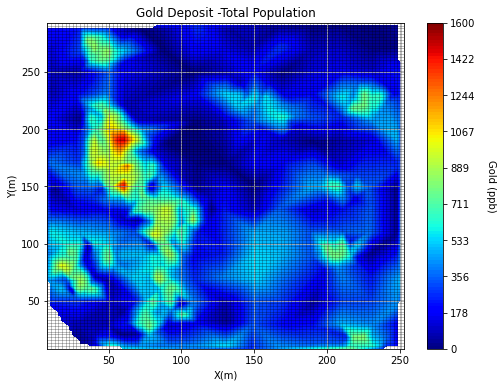

In [9]:
# Setting information for grid model and maximo value for regional variable VR 
nx = 99; ny = 115; cell_size = 2.5                                  # grid number of cells and cell size
xmin = 8; ymin = 8;                                                 # grid origin
xmax = xmin + (nx) * cell_size; ymax = ymin + (ny) * cell_size      # calculate the extent of model
seed = 74073                                                        # random number seed  for stochastic simulation    
vmin = 0; vmax = 1600; cmap = 'jet' #plt.cm.plasma                  # color min and max and using the jet or plasma color map
fig_name='F0GoldDeposit.tif'
# Visual representation of Population: Total 
fig=pixelplt(gridVR,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,'Gold Deposit -Total Population','X(m)','Y(m)','Gold (ppb)',cmap,fig_name)
#pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name)

plt.show()

# plt.savefig(fig_name,dpi=500,bbox_inches="tight")

# 1st Sampling - Initial Drill Exploration
Regular sampling 50x50 grid on a 2D Space


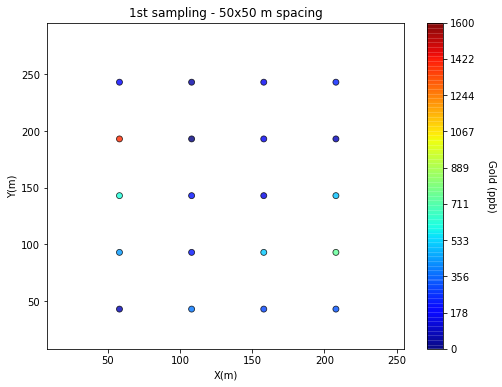

,X,Y,Gold sampled
count,20.000000,20.000000,20.000000
mean,133.000000,143.000000,341.352451
std,57.353933,72.547625,314.348291
min,58.000000,43.000000,5.876658
25%,95.500000,93.000000,159.530908
50%,133.000000,143.000000,237.272838
75%,170.500000,193.000000,458.690027
max,208.000000,243.000000,1381.271418


In [10]:
sampling_ncell = cell_size                    # size of the population grid
mx=20; my=20                                  # Distance X and Y as mx , my for regular sampling on units 'sampling_ncell' 
samples = regular_sample(gridVR,xmin,xmax,ymin,ymax,sampling_ncell,mx,my,nx,ny,'Gold sampled')
fig=locmap(samples,'X','Y','Gold sampled',xmin,xmax,ymin,ymax,vmin,vmax,'1st sampling - 50x50 m spacing','X(m)','Y(m)','Gold (ppb)',cmap,
       'F3_GoldSamples')
pd.DataFrame(samples).describe()

## 2nd Sampling -  Infill Drilling
Aditional Regular sampling on 17.5x17.5 grid on a 2D Space# 

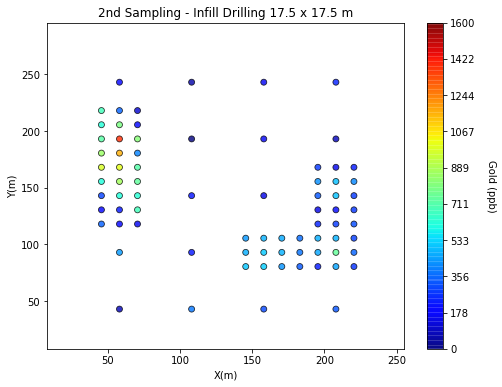

,X,Y,Gold sampled
count,78.000000,78.000000,78.000000
mean,134.602564,138.833333,425.120710
std,66.977868,50.390789,261.570372
min,45.500000,43.000000,5.876658
25%,58.000000,96.125000,235.008348
50%,158.000000,136.750000,372.688248
75%,195.500000,168.000000,514.926799
max,220.500000,243.000000,1381.271418


In [11]:
InfillSample = regular_sample(gridVR,xmin,xmax,ymin,ymax,sampling_ncell,5,5,nx,ny,'Gold sampled') # Infill on 5*2.5 = 17.5 x 17.5 grid
sampleSet=SampleInsideV(InfillSample,35, 76,115,226,'X','Y') # Infill sample inside Region 1 as results of preliminary Gold Values

samples=samples.append(sampleSet,ignore_index=False)
samples.drop_duplicates(inplace=True)
sampleSet=SampleInsideV(InfillSample,195, 225,70,170,'X','Y') # Infill sample inside Region 2 as results of preliminary Gold Values

samples=samples.append(sampleSet,ignore_index=False)
samples.drop_duplicates(inplace=True)
sampleSet=SampleInsideV(InfillSample,135, 210,75,110,'X','Y') # Infill sample inside Region 3 as results of preliminary Gold Values 

samples=samples.append(sampleSet,ignore_index=True) # End of 2do Campaign 
samples.drop_duplicates(inplace=True)
fig2=locmap(samples,'X','Y','Gold sampled',xmin,xmax,ymin,ymax,vmin,vmax,'2nd Sampling - Infill Drilling 17.5 x 17.5 m','X(m)','Y(m)','Gold (ppb)',cmap,
       'F4_GoldSamples')
pd.DataFrame(samples).describe()


## 3nd Sampling -  Final Infill Drilling
Aditional Regular sampling on 17.5x17.5 grid on a 2D Space# 

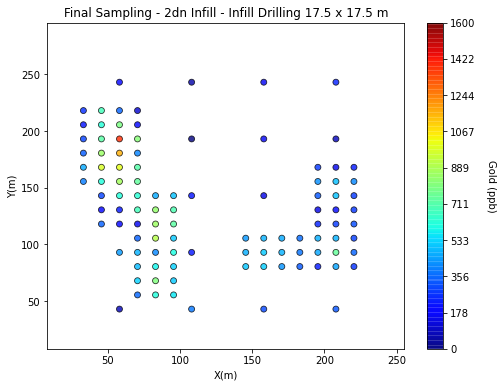

,X,Y,Gold sampled
count,105.000000,105.000000,105.000000
mean,118.833333,132.761905,452.212989
std,64.698512,50.471960,247.289661
min,33.000000,43.000000,5.876658
25%,58.000000,93.000000,278.599991
50%,95.500000,130.500000,427.338764
75%,195.500000,168.000000,584.896066
max,220.500000,243.000000,1381.271418


In [12]:
sampleSet=SampleInsideV(InfillSample,25, 45,150,225,'X','Y') # Infill sample 
samples=samples.append(sampleSet,ignore_index=False)
samples.drop_duplicates(inplace=True)

sampleSet=SampleInsideV(InfillSample,70, 100,55,155,'X','Y') # Infill sample 
samples=samples.append(sampleSet,ignore_index=False)
samples.drop_duplicates(inplace=True)

fig2=locmap(samples,'X','Y','Gold sampled',xmin,xmax,ymin,ymax,vmin,vmax,'Final Sampling - 2dn Infill - Infill Drilling 17.5 x 17.5 m','X(m)','Y(m)','Gold (ppb)',cmap,
       'F5_GoldSamples')
pd.DataFrame(samples).describe()


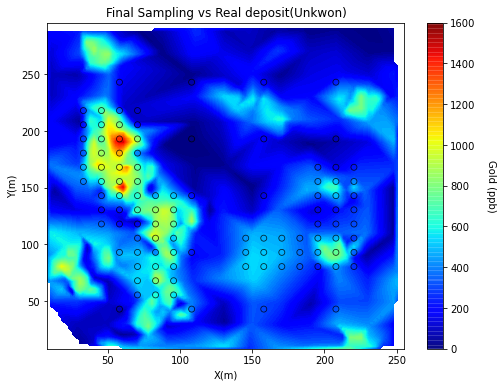

In [13]:
# Final Sampling vs Real deposit (always unkwon)
fig4=locpix(gridVR,xmin,xmax,ymin,ymax,sampling_ncell,vmin,vmax,samples,'X','Y','Gold sampled','Final Sampling vs Real deposit(Unkwon)','X(m)','Y(m)',
       'Gold (ppb)',cmap,'F6_GoldSamples')


#  What happen is sampled as regular distance
1. We discover a ore Deposit using regular and irregular sampling distance !!!!
2. Means, variance and std help to identify properties

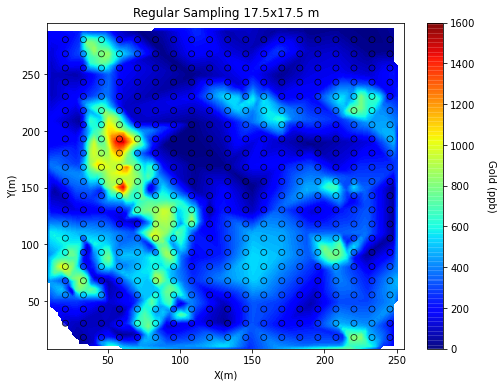

,X,Y,Gold regular
count,418.000000,418.000000,417.000000
mean,133.000000,149.250000,298.740087
std,68.547363,79.398641,208.318863
min,20.500000,18.000000,5.876658
25%,70.500000,80.500000,145.914225
50%,133.000000,149.250000,263.818779
75%,195.500000,218.000000,408.250009
max,245.500000,280.500000,1381.271418


In [14]:
sampleRegTotal = regular_sample(gridVR,xmin,xmax,ymin,ymax,sampling_ncell,5,5,nx,ny,'Gold regular')
fig4=locpix(gridVR,xmin,xmax,ymin,ymax,sampling_ncell,vmin,vmax,sampleRegTotal,'X','Y','Gold regular','Regular Sampling 17.5x17.5 m','X(m)','Y(m)',
       'Gold (ppb)',cmap,'F7_GoldSamples')
pd.DataFrame(sampleRegTotal).describe()

### Stats for All Deposit - Population

In [15]:
sumPoblacion=np.nansum(gridVR);meanPoblacion=np.nanmean(gridVR);stdPoblacion=np.nanstd(gridVR);countPoblacion=sumPoblacion/meanPoblacion
percValue=np.nanpercentile(gridVR,[25,50,75])
labelItem=["count","mean","std","min","25%","50%","75%","max"]
valueItem=[countPoblacion,meanPoblacion,stdPoblacion,np.nanmin(gridVR),percValue[0],percValue[1],percValue[1],np.nanmax(gridVR)]
#print(labelItem,valueItem)
tablaSta=pd.DataFrame(valueItem,index=labelItem,columns=['Gold Total'])
tablaSta

,Gold Total
count,10993.000000
mean,300.416080
std,209.286851
min,2.738690
25%,142.580529
50%,261.162793
75%,261.162793
max,1471.637479


### Basic Stat including Regular Sampling

In [16]:
colItem=sampleRegTotal.describe().filter(items=['Gold regular'])
tablaSta=pd.DataFrame.join(colItem,tablaSta)
colItem

tablaSta

,Gold regular,Gold Total
count,417.000000,10993.000000
mean,298.740087,300.416080
std,208.318863,209.286851
min,5.876658,2.738690
25%,145.914225,142.580529
50%,263.818779,261.162793
75%,408.250009,261.162793
max,1381.271418,1471.637479


### Basic Stat Including Non regular Sampling

In [17]:
 #lsuffix='_caller'
colItem=samples.describe().filter(items=['Gold sampled'])
tablaSta=pd.DataFrame.join(colItem,tablaSta)
tablaSta

,Gold sampled,Gold regular,Gold Total
count,105.000000,417.000000,10993.000000
mean,452.212989,298.740087,300.416080
std,247.289661,208.318863,209.286851
min,5.876658,5.876658,2.738690
25%,278.599991,145.914225,142.580529
50%,427.338764,263.818779,261.162793
75%,584.896066,408.250009,261.162793
max,1381.271418,1381.271418,1471.637479


# Regular Sampling is good to means average grade for Total Population
### But Regular sampling doesn't represent the VR value  of interest when Discovering a Gold Deposit .... 

<AxesSubplot:title={'center':'Gold Standar Desviation - ppb'}>

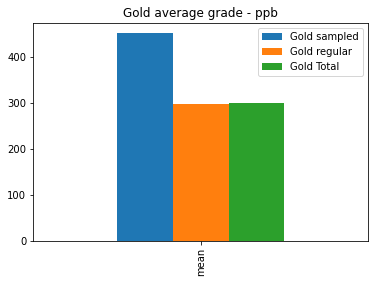

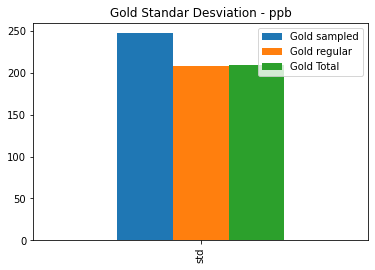

In [18]:
tablaSta.filter(like='mean', axis=0).plot(kind='bar',use_index=True,title="Gold average grade - ppb")
tablaSta.filter(like='std', axis=0).plot(kind='bar',use_index=True,title="Gold Standar Desviation - ppb")

# Conclusion

1. Regular sampling is useful as the initial stage from discovering a "mineral resource". But irregular sampling are adopted as main procedure when discovering deposit
2. Average grade of these irregular sampling represent the real value for the quality of the "mineral resource" but not represent all the population.
3. These "mineral resource" usually are treated as independent a second population are required to define..... calling Ore Deposit or "Geostatistic domain"
4. Inferential Stats was used from 2nd to end stage of sampling.
5. Stats of poblations grouped by domain is better. But if we want to represent the average grade of the Total Population may be "Declustering procedure" are better to use. 

### See Declustering tecnique for corrected mean from clustered sampling  as these case